In [1]:
# General imports
import pandas as pd
import numpy as np
import re
import os

# Asto stuff imports
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun, get_body
import astropy.units as u
from astroplan import moon_illumination
from astropy.time import Time, TimeDelta

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import imageio.v2 as imageio

In [2]:
# Observation location, lat, long, elevation, min alt, mag limit
BPO = [51.372840, -2.319224, 200, 30, 12]

# Observation Window
start_date = "2025-10-01T18:00:00"
end_date   = "2025-10-31T06:00:00"

#The Varible stars from Monson paper
Monson_RRL =["SW And", "XX And", "WY Ant", "X Ari", "ST Boo", "UY Boo", "RR Cet", "W Crt", "UY Cyg", "XZ Cyg", "DX Del", "SU Dra", "SW Dra", "RX Eri", "SV Eri", "RR Gem", "TW Her", "VX Her", "SV Hya", "V Ind", "RR Leo", "TT Lyn", "RR Lyr", "RV Oct", "UV Oct", "AV Peg", "BH Peg", "BB Pup", "HK Pup", "RU Scl", "AN Ser", "V0440 Sgr", "V0675 Sgr", "AB UMa", "RV UMa", "TU UMa", "UU Vir", "AE Boo", "TV Boo", "ST CVn", "UY Cam", "YZ Cap", "RZ Cep", "RV CrB", "CS Eri", "BX Leo", "DH Peg", "RU Psc", "SV Scl", "AP Ser", "T Sex", "MT Tel", "AM Tuc", "SX UMa", "CU Com"]

# Constants for air mass calcs
rad_earth = 6371000  # Earth's radius in meters
h0 = 7610  # Scale height of atmosphere in meters
P0 = 101325  # Sea level atmospheric pressure in Pa

# Finding targets

In [3]:
def Get_GAIA_RRL(site, query=False):

    """
    Function that searches the gaia DR3 database for RRL stars that are visible from the observation site,
    based on location and limiting apparent magnitude. Then saves the found results to a csv file
    OR the csv file is just read in if the search isn't required
    Returns the list of potential observations candidates with their id, ra/dec coords, their periods, 
    mags in gaia filters and best classification of the RRL star
    """

    # First checks whether the gaia DR3 needs to be used
    if query:
        # Min and max declaration visible from the observation site,
        # helps to reduce the star retrieved from the database
        dec_min = site[0] - (90 - site[3])
        dec_max = site[0] + (90 - site[3])
        dec_max = min(dec_max, 90.0)

        # The ADQL that is used to query the GDR3 database and get the stars we wanr
        ADQL = f"""
        SELECT  rr.source_id, gs.ra, gs.dec,
            gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag,
            rr.pf, rr.best_classification
        FROM gaiadr3.vari_rrlyrae AS rr
        JOIN gaiadr3.gaia_source AS gs
        ON rr.source_id = gs.source_id
        WHERE gs.dec BETWEEN {dec_min:} AND {dec_max:}
            AND gs.phot_bp_mean_mag <= {site[4]}
        """
    
        job = Gaia.launch_job_async(ADQL)      # Searching Gaia
        results = job.get_results()            # Getting the result
        results.write("data/vari_rrlyrae.csv", format="csv", overwrite=True)      # Saveing the results so it doesn't have to redo this
    
    else:
        RRL = pd.read_csv("data/vari_rrlyrae.csv")                                # If the search is not done then just read the csv file 
        
    RRL.rename(columns={'source_id' : 'main_id', 'pf' : 'period'}, inplace=True)  # Renaming columns for easier reading
    
    return RRL

In [4]:
def visabliity(df, site, start_date, end_date, dt_minutes=10.0, sun_night_threshold=-12.0, rename=False, save=True):

    """
    Takes a df containg stars with either ra/dec coords and calcultes how many hours it is visiable at night above an altitude
    Does this by calcuting the stars altitude realative to the observation site at incriemtns between the stars and end dates. 
    If it is dark (calculted from the suns altitude) and above the minimum altitude then the star is visable.
    Also has the option to turn the GAIA id name which is a long string of numbers to the traditional names, easier to identify.
    Has option to save the df, saving time in reruns by just reding in the already created df
    """
    
    # Time grid
    tstart = Time(start_date)
    tend = Time(end_date)

    # Creates an array of times with intervals of df mins
    n_minutes = int(np.ceil((tend - tstart).to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Location and ref frame
    location = EarthLocation(lat=site[0]*u.deg, lon=site[1]*u.deg, height=site[2]*u.m)
    frame = AltAz(obstime=times, location=location)

    # Sun altitude and night mask
    sun_altitudes = get_sun(times).transform_to(frame).alt.deg
    is_night = sun_altitudes < sun_night_threshold

    # No night in interval, stops function
    if not np.any(is_night):
        filtered_df = df.iloc[0:0].copy()
        if return_visibility_hours:
            return filtered_df, {}
        return filtered_df
    
    # Making sure ra/dec are plain numpy arrays
    ra = np.asarray(df["ra"].values, dtype=float)
    dec = np.asarray(df["dec"].values, dtype=float)

    # Coords of the stars in ra/dec then converted to alt/az
    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
    altaz = coords[:, None].transform_to(frame) 
    altitudes = altaz.alt.deg.T    # Height in the sky

    # Apply night mask, only times at night
    night_altitudes = altitudes[is_night, :]

    # True if any time in night  time altitudes >= min altitude
    meets_alt = np.any(night_altitudes >= site[3], axis=0)

    # Compute hours visible for every star (even 0) so we can add to df
    dt_hours = dt_minutes / 60.0
    hours_per_star = np.sum(night_altitudes >= site[3], axis=0) * dt_hours

    # Attach hours to the original df and select rows where the star is visable
    df["hours_visible"] = hours_per_star
    filtered_df = df.loc[hours_per_star > 0].reset_index(drop=True)
    
    filtered_df['main_id'] = filtered_df['main_id'].astype(str) 

    if rename:
        Simbad.add_votable_fields("ids")
        for i, gaia_id in enumerate(filtered_df["main_id"]):
            result = Simbad.query_object(f"Gaia DR3 {gaia_id}")
            if result is not None and len(result) > 0:
                aliases = result["ids"][0].split("|")
                nice_name = None
                for alias in aliases:
                    alias = alias.strip()
                    if alias.startswith("V* "):
                        nice_name = alias[3:]  # Getting rid of V*
                        break
                if nice_name:    # Only overwrite if a nice name was found
                    filtered_df.loc[i, "main_id"] = nice_name
                else:
                    filtered_df.loc[i, "main_id"] = result["main_id"][0]

    if save: filtered_df.to_csv('data/RRL_targets.csv', index=False)

    return filtered_df

In [5]:
# Takes a while so just reading in the csv file thats these produce is faster
"""
# Getting candidate stars by declination/flux prefilter
candidates = Get_GAIA_RRL(BPO, query=True)

# Filtering by visabliity during timeframe
RRL = visabliity(candidates, BPO, start_date, end_date, rename=True, save=True)
"""

'\n# Getting candidate stars by declination/flux prefilter\ncandidates = Get_GAIA_RRL(BPO, query=True)\n\n# Filtering by visabliity during timeframe\nRRL = visabliity(candidates, BPO, start_date, end_date, rename=True, save=True)\n'

In [6]:
# RRL stars from Gaia that are visiable and brighter than an arbitry limit
maybe_RRL_targets = pd.read_csv("data/RRL_targets.csv")

# Restrict to Monson list
RRL = maybe_RRL_targets[maybe_RRL_targets["main_id"].isin(Monson_RRL)].reset_index(drop=True)

# Print the filtered DataFrame including the hours visible, sorted by hours descending
print("Stars that appear above 30° during night in the interval (sorted by hours_visible):")
print(RRL[["main_id", "ra", "dec", "hours_visible"]].sort_values("hours_visible", ascending=False).to_string(index=False))

Stars that appear above 30° during night in the interval (sorted by hours_visible):
main_id         ra       dec  hours_visible
 SW Dra 184.443944 69.510588     328.000000
 UY Cam 119.745316 72.787533     328.000000
 RZ Cep 339.805873 64.859351     327.833333
 SW And   5.929506 29.400923     288.166667
 RU Psc  18.608950 24.415476     285.833333
 SU Dra 174.485330 67.329393     229.833333
 XZ Cyg 293.122787 56.388085     218.833333
 BH Peg 343.254208 15.787665     210.666667
 AV Peg 328.011712 22.574789     196.666667
 UY Cyg 314.117903 30.427828     187.000000
 RR Lyr 291.365640 42.783489     171.333333
 DH Peg 333.856936  6.822620     167.000000
 RR Cet  23.034104  1.341534     158.500000
 RR Gem 110.389712 30.883189     144.500000
 DX Del 311.868209 12.464110     139.166667
 TT Lyn 135.781920 44.585400     127.333333
 TW Her 268.630021 30.410456      96.000000
 SX UMa 201.555538 56.256964      70.166667
 RV UMa 203.325143 53.987198      54.166667
 RV CrB 244.857596 29.713114      46

# Plotting airmass

In [7]:
def calc_airmass(alt, model):

    """
    Function to calculate air mass of the atmosphere at given angles. Uses three methods of varying accuracy 
    Base of this code taken from Sloan scripts but have been rewritten a bit
    """

    alt = np.asarray(alt, dtype=float)
    airmass = np.full_like(alt, np.nan)  # full-length array filled with nans, so any empty values not plotted

    # Mask for altitudes above horizon
    mask = alt > 0
    theta = 90 - alt[mask]
    theta_rad = np.radians(theta)  #calcultions in radians


    # Model 1: Flat Earth, constant pressure
    if model == 1:
        airmass_model1 = 1 / np.cos(theta_rad)      # Simple trig, distance depends on angle from the zenith
        zenith_idx = np.argmax(alt[mask])
        airmass_model1 /= airmass_model1[zenith_idx]       # Normlised to when stars mas lowest airmass
        airmass[mask] = airmass_model1


    # Model 2: Flat Earth, exponential pressure 
    elif model == 2:
        s_max = 200000.0   # maximum slant distance to integrate m
        ds = 10.0          # step size m
        s_array = np.arange(0.0, s_max + ds, ds)
        airmass_model2 = np.zeros_like(theta)
        for i, t_rad in enumerate(theta_rad):
            h = s_array * np.cos(t_rad)              # Height along slant ray
            p = np.exp(-h / h0)                      # Pressure along path (relative units, all gets normalised anyway)           
            integral = np.trapezoid(p, s_array)      # Numeric integral of pressure along the height
            airmass_model2[i] = integral / h0        # divide by vertical column integral to get relative airmass
        airmass_model2 /= np.nanmin(airmass_model2)  # Normalise to stars lowest airmass
        airmass[mask] = airmass_model2


    # Model 3: Parabolic Earth, constant pressure
    elif model == 3:
        airmass_model3 = []
        for t in theta:
            t_rad = np.radians(t)  # Calcs in radians
            # term 1: horizontal component of the path length through atmosphere
            # Based on Earth's curvature and geometry
            term1 = -rad_earth * np.tan(np.radians(90 - t)) / np.sin(t_rad)    
            # term 2: vertical component of the path length, accounting for Earth's curvature
            # Includes a square root term to model the extended path through curved atmosphere
            term2 = (1 / np.sin(t_rad)) * np.sqrt(rad_earth**2 * np.tan(np.radians(90 - t))**2 + 2 * rad_earth * h0)
            am = term1 + term2     
            airmass_model3.append(am)   # Total airmass estimate for this angle
        airmass_model3 = np.array(airmass_model3)
        zenith_idx = np.argmax(alt[mask])             # Normalise to star best visibility, minimum airmass during the night
        airmass_model3 /= airmass_model3[zenith_idx]
        airmass[mask] = airmass_model3 


    # Model 4: Circular Earth, exponential pressure
    elif model == 4:
        x_step = 10     # horizontal step size in meters
        x = np.arange(x_step*2.1, h0 * 10 + 1, x_step)
        airmass_model4 = np.zeros_like(theta)
        for i, t in enumerate(theta):
            dr = np.sqrt((x[1] - x[0])**2 + (np.tan(np.radians(90 - t)) * (x[1] - x[0]))**2)   # Compute the slant path step length (dr) for this angle
            for xi in x:
                y = np.tan(np.radians(90 - t)) * xi        # Vertical displacement along the ray
                r = np.sqrt(xi**2 + (rad_earth + y)**2)    # Distance from Earth's center to the ray point
                h = r - rad_earth                          # Height above Earth's surface
                p = P0 * np.exp(-h / h0)                   # Atmospheric pressure at this height
                airmass_model4[i] += p * dr                # Accumulate pressure-weighted path length
        zenith_idx = np.argmax(alt[mask])
        airmass_model4 /= airmass_model4[zenith_idx]       # Normlised to when stars mas lowest airmass
        airmass[mask] = airmass_model4


    else:
        raise ValueError("Invalid model number. Choose 1–4.")

    return airmass

In [8]:
def plot_star_airmass(df, names, site, start_date, end_date, model=4, dt_minutes=10.0):

    """
    Calcultes the airmass of the stars between a time frame and plots them 
    with shading indicating how dark the sky is calculted from the suns altitude
    I need to update this to calculte it properly rather than just using the built in attribute
    """
    
    # Select stars
    plot_stars = df[df["main_id"].isin(names)]
    if plot_stars.empty: raise ValueError("No matching stars found in data frame")

    # Build time array from start_date to end_date with steps of dt_minutes
    tstart = Time(start_date)
    tend = Time(end_date)
    if tend <= tstart: raise ValueError("end_date must be after start_date")

    n_minutes = int(np.ceil((tend - tstart).to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Observer frame
    location = EarthLocation(lat=site[0]*u.deg, lon=site[1]*u.deg, height=site[2]*u.m)
    frame = AltAz(obstime=times, location=location)

    plt.figure(figsize=(12,6))
    ax = plt.gca()

    # Sun altitudes for shading
    sun_altitudes = get_sun(times).transform_to(frame).alt.deg
    
    # Colours depending on sunlight
    sky_shade = {"daylight": "#ffffcc", "civil": "#ffe6cc", "nautical": "#e6f2ff", "astronomical": "#e6e6ff", "night": "#d9d9d9"}

    # Shade background by sun altitude bands
    for i in range(len(times) - 1):
        alt = sun_altitudes[i]
        t0 = times[i].plot_date
        t1 = times[i+1].plot_date

        if alt > 0: shade = sky_shade["daylight"]
        elif alt > -6: shade = sky_shade["civil"]
        elif alt > -12: shade = sky_shade["nautical"]
        elif alt > -18: shade = sky_shade["astronomical"]
        else: shade = sky_shade["night"]

        ax.axvspan(t0, t1, color=shade)    #setting that section of the graph to the corresponding colour

    # Compute alt/az for all selected stars at once
    ra = np.asarray(plot_stars["ra"].values, dtype=float)
    dec = np.asarray(plot_stars["dec"].values, dtype=float)
    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
    
    for i, row in plot_stars.iterrows():
        coord = SkyCoord(ra=row["ra"]*u.deg, dec=row["dec"]*u.deg)
        altaz = coord.transform_to(frame)
        altitudes = altaz.alt.deg

        # Plotting airmass using all the different models
        if model == "all":
            model_labels = {
                1: "Flat, constant pressure",
                2: "Flat, exponential pressure",
                3: "Parabolic Earth",
                4: "Spherical Earth, exponential pressure"
            }
            colors = {1: "C0", 2: "C1", 3: "C2", 4: "C3"}

            for m in range(1, 5):
                airmass = calc_airmass(altitudes, m)
                label = f"{row['main_id']} — {model_labels[m]}"
                plt.plot(times.plot_date, airmass, label=label, color=colors[m], linewidth=1.5)
        else:
            airmass = calc_airmass(altitudes, model)
            plt.plot(times.plot_date, airmass, label=row["main_id"], linewidth=1.5)

    # Formatting
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d-%m-%Y\n%H:%M"))
    plt.ylabel("Altitude (deg)")
    plt.xlabel("Time")
    plt.ylabel("Airmass")
    plt.ylim(0.5, 5)
    plt.legend(loc="best", fontsize="small", ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

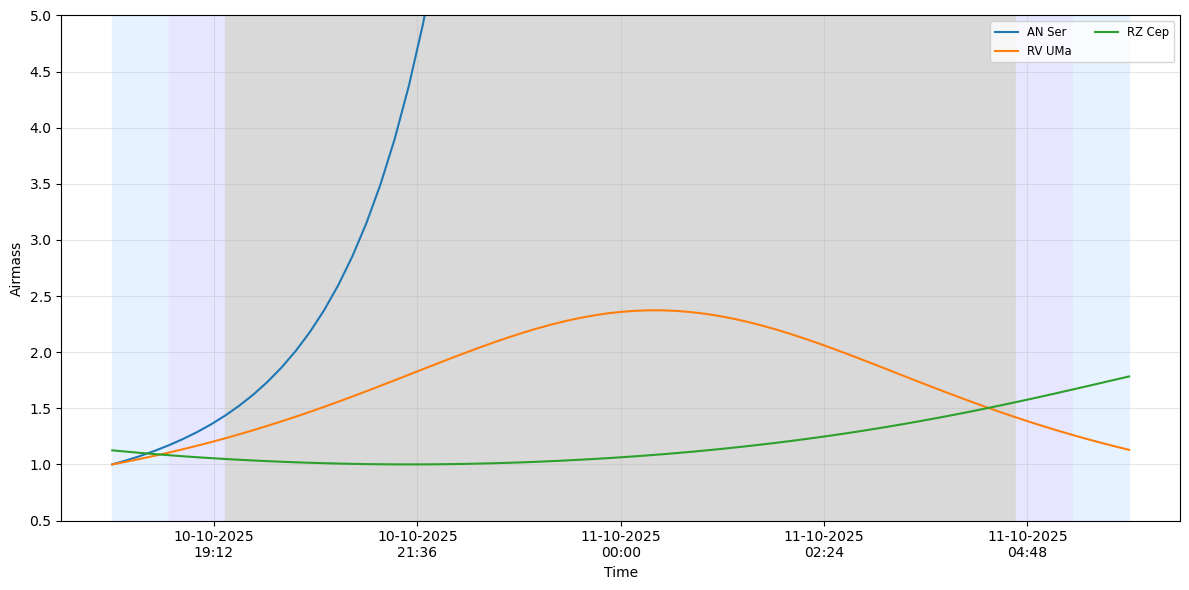

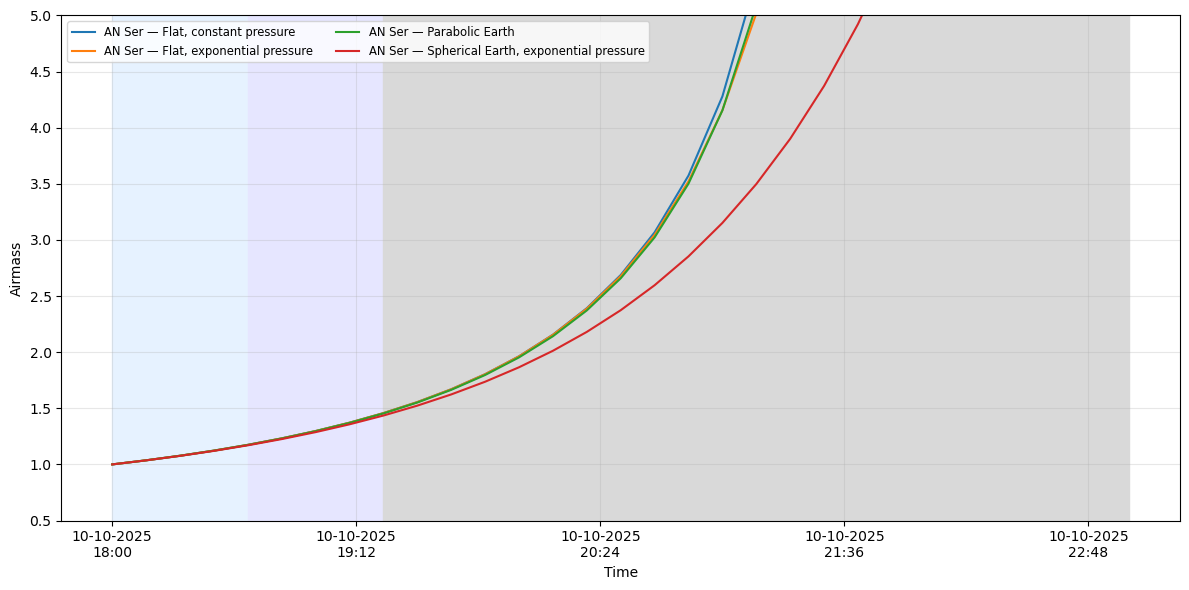

In [9]:
plot_stars = ["RV UMa", "RZ Cep", "AN Ser"]  # Small number of different examples
#plot_stars = RRL['main_id'].to_list()    # Stars found through SIMBAD

# Plot stars airmass during a window
plot_star_airmass(RRL, plot_stars, BPO, start_date="2025-10-10T18:00:00", end_date="2025-10-11T06:00:00", model = 4)

# Plotting all the methods
plot_star_airmass(RRL, ['AN Ser'], BPO, start_date="2025-10-10T18:00:00", end_date="2025-10-10T23:00:00", model = 'all')

# Standard stars

In [10]:
# Reading in a file containing info about landolt standard stars in the northen hemisphere
All_SS = pd.read_csv("data/landolt_north.csv",delimiter = "|")
All_SS.columns = ['oid', 'main_id', 'ra', 'dec']

# Filter for visabliity using the same method as the RRl stars
SS = visabliity(All_SS, BPO, start_date, end_date, save=False)

In [11]:
def get_gaia_id_from_name(nice_name):
    """
    Reverse of the code in the visabliity script, finds the GAIA ID of a star from the simbad ID
    """
    Simbad.add_votable_fields("ids")                # Adding field we want
    result = Simbad.query_object(nice_name)         # Searching database for that name
    if result is not None and len(result) > 0:      # Checks if it has anything
        ids = result["ids"][0]                      # Gets the long string of all the different IDS
        match = re.search(r"Gaia DR3 (\d+)", ids)   # Trys to finds the GAIA ID
        if match:
            return match.group(1)                   # Returns GAIA ID if found
    return None

def get_gaia_magnitudes(gaia_id):
    """
    Gets the magnitudes of a star in the GAIA filters from the GAIA DR3 database using it's GAIA ID
    """
    query = f"""
    SELECT phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
    FROM gaiadr3.gaia_source
    WHERE source_id = {gaia_id}
    """
    job = Gaia.launch_job(query)   # Searching for the mags of a star in the three filters
    result = job.get_results()     # Get the results
    if len(result) > 0:            # If found the mags then return then
        return result[0]["phot_g_mean_mag"], result[0]["phot_bp_mean_mag"], result[0]["phot_rp_mean_mag"]
    return None, None, None

def get_mags_from_name(nice_name):
    """
    Function that uses the above and returns none if mags or GAIA ID can't be found, stops the df from breaking
    """
    gaia_id = get_gaia_id_from_name(nice_name)
    if gaia_id:
        return get_gaia_magnitudes(gaia_id)
    return None, None, None

In [12]:
def match_to_standards(vars_df, stds_df, save):

    """
    Function that matches the RRL stars to the standard stars based on seperation
    Creates a new df that contains all the old RRL data as well as it's closest standard star its ra/dec and mags and seperation
    """
    
    # Ensure numeric arrays
    vars_ra = np.asarray(vars_df["ra"].values, dtype=float)
    vars_dec = np.asarray(vars_df["dec"].values, dtype=float)
    stds_ra = np.asarray(stds_df["ra"].values, dtype=float)
    stds_dec = np.asarray(stds_df["dec"].values, dtype=float)

    # Build SkyCoord objects
    coords_vars = SkyCoord(ra=vars_ra * u.deg, dec=vars_dec * u.deg)
    coords_stds = SkyCoord(ra=stds_ra * u.deg, dec=stds_dec * u.deg)

    # Match each variable to the nearest standard star
    idx, sep2d, _ = coords_vars.match_to_catalog_sky(coords_stds)

    g_mags, bp_mags, rp_mags = [], [], []

    for name in stds_df.iloc[idx]["main_id"].values:
        g, bp, rp = get_mags_from_name(name)
        g_mags.append(g)
        bp_mags.append(bp)
        rp_mags.append(rp)

    # Build result DataFrame
    result = vars_df.copy().reset_index(drop=True)
    result["matched_standard"] = stds_df.iloc[idx]["main_id"].values
    result["standard_ra"] = stds_df.iloc[idx]["ra"].values
    result["standard_dec"] = stds_df.iloc[idx]["dec"].values
    result["standard_g_mag"] = g_mags
    result["standard_bp_mag"] = bp_mags
    result["standard_rp_mag"] = rp_mags
    result["sep_arcsec"] = sep2d.arcsec

    if save: result.to_csv('data/matched_targets.csv', index=False)  # Save dataframe so don't have to repeat this

    return result

In [13]:
# Find nearest standard for every RRL and its mag, takes a while so ran once and reading in csv file
#matched = match_to_standards(RRL, SS, save=True)

# Reading in saved df - much faster
matched = pd.read_csv("data/matched_targets.csv")

# Moon illumination

In [14]:
def plot_moon_illumination(start_date, end_date, dt_minutes=10.0):
    
    """
    Plots the moons illumination across a time period
    """
    
    tstart = Time(start_date)
    tend = Time(end_date)
    n_minutes = int(np.ceil((tend - tstart).to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min   # Time grid

    # Moon illumination at each time
    illumination = moon_illumination(times)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(times.datetime, illumination * 100, color="k")
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d-%m-%Y\n%H:%M"))
    plt.ylabel("Moon Illumination (%)")
    plt.xlabel("Date and Time")
    plt.title("Moon Illumination Over Time")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

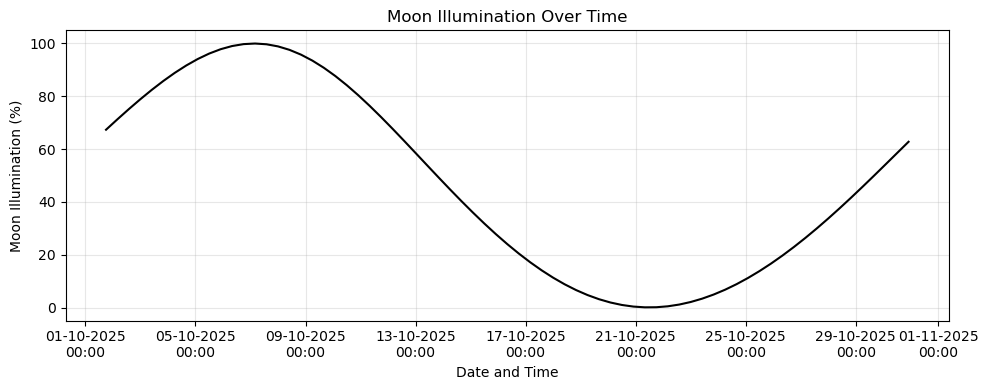

In [15]:
plot_moon_illumination(start_date, end_date, dt_minutes=600)

# Complete plots

In [16]:
def plot_night(star_name, matched_df, site, tstart, duration, dt_minutes=15.0, show=True, save=False):

    """
    Creates a polar plot of the paths of objects of intrest during a night
    Plots the path of the RRL and standard stars as well as the moon and its illumination
    Also plots the shaded region where stars are too low in the sky to see
    Can also save the plots -> saved plots can be used to make animation of a star during consecutive nights
    """
    
    # Find the row for the requested star
    row = matched_df[matched_df["main_id"] == star_name]

    # Extract star info
    var_ra = row.iloc[0]["ra"]
    var_dec = row.iloc[0]["dec"]
    var_name = row.iloc[0]["main_id"]
    std_ra = row.iloc[0]["standard_ra"]
    std_dec = row.iloc[0]["standard_dec"]
    std_name = row.iloc[0]["matched_standard"]

    # Time grid
    tend = tstart + duration
    n_minutes = int(np.ceil(duration.to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Observer location and frame
    location = EarthLocation(lat=site[0]*u.deg, lon=site[1]*u.deg, height=site[2]*u.m)
    frame = AltAz(obstime=times, location=location)

    # SkyCoords
    var_coord = SkyCoord(ra=var_ra*u.deg, dec=var_dec*u.deg)
    std_coord = SkyCoord(ra=std_ra*u.deg, dec=std_dec*u.deg)

    # Moon SkyCoords and illumination
    moon_coord = get_body("moon", times, location).transform_to(frame)
    moon_illum = moon_illumination(times)

    # To AltAz
    var_altaz = var_coord.transform_to(frame)
    std_altaz = std_coord.transform_to(frame)

    # Filter for altitudes above horizon
    mask_var = var_altaz.alt > 0*u.deg
    mask_std = std_altaz.alt > 0*u.deg
    mask_moon = moon_coord.alt > 0*u.deg

    # Convert to polar coordinates
    az_var = var_altaz.az[mask_var].rad
    r_var = var_altaz.alt[mask_var].deg
    az_std = std_altaz.az[mask_std].rad
    r_std = std_altaz.alt[mask_std].deg
    az_moon = moon_coord.az[mask_moon].rad
    r_moon = moon_coord.alt[mask_moon].deg
    illum_moon = moon_illum[mask_moon]

    # Create polar plot
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(90, 0)  # Zenith at center, horizon at edge
    ax.grid(True, alpha=0.2)

    # ALt/Az label
    alt_ticks = np.arange(0, 100, 15)  # 0 to 90
    alt_labels = [f"{alt}°" for alt in alt_ticks]
    ax.set_rgrids(alt_ticks, labels=alt_labels, angle=20)
    ax.text(np.deg2rad(20), -10, "Altitude (deg)", ha="left", va="center", fontsize=10)
    ax.text(0, -8, "Azimuth (deg)", ha="center", va="bottom", fontsize=10)

    # Compass labels
    compass_labels = {"N": 0, "E": 90, "S": 180, "W": 270}
    for label, deg in compass_labels.items():
        angle_rad = np.deg2rad(deg)
        ax.text(angle_rad, -15, label, ha="center", va="center", fontsize=10, fontweight="bold")

    # Add date label to top-right corner of the plot
    date_str = "Night of observation: " + (tstart.datetime.strftime("%d.%m.%Y"))
    fig.text(0.05, 0.95, date_str, fontsize=10)

    # Shade region below minimum altitude
    ax.plot(np.linspace(0, 2*np.pi, 360), [site[3]]*360, color="gray", linestyle="--", linewidth=1)
    theta = np.linspace(0, 2*np.pi, 500)
    ax.fill_between(theta, site[3], 0, color="lightgray", alpha=0.4)

    # Plot paths    
    ax.plot(az_var, r_var, color="blue", linewidth=2)
    ax.scatter(az_var[0], r_var[0], color="blue", s=60, marker="x")      # Marks the start of star path with an 'x'
    
    ax.plot(az_std, r_std, color="green", linestyle="--")
    ax.scatter(az_std[0], r_std[0], color="green", s=60, marker="x")

    # Label star names
    if len(r_var) > 0:
        i_var_peak = np.argmax(r_var)
        ax.text(az_var[i_var_peak]+6, r_var[i_var_peak], var_name, color="blue", fontsize=9)
    if len(r_std) > 0:
        i_std_peak = np.argmax(r_std)
        ax.text(az_std[i_std_peak], r_std[i_std_peak]+5, std_name, color="green", fontsize=9)

    # Plotting moon stuff if visable in theh sky
    if len(r_moon) > 0:
        # Moon path with illumination shading
        moon_colors = plt.cm.Greys(illum_moon)
        ax.scatter(az_moon, r_moon, c=moon_colors, s=20)
        ax.scatter(az_moon[0], r_moon[0], color=moon_colors[0], s=80, marker="x")
        # Label moon illumination at highest point
        i_peak = np.argmax(r_moon)
        illum_pct = int(illum_moon[i_peak] * 100)
        ax.text(az_moon[i_peak], r_moon[i_peak] - 10, f"Moon\n{illum_pct}%", fontsize=9)

    # Save and/or showing
    if save:
        fixed_name = star_name.replace(" ", "_")
        start_str = tstart.datetime.strftime("%Y-%m-%d_%H-%M")
        end_str = tend.datetime.strftime("%Y-%m-%d_%H-%M")
        filename = f"{fixed_name}_{start_str}_to_{end_str}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")

    if show: plt.show()
    else: plt.close()


In [17]:
def animate(star_name, start_night, nights, duration, output_folder="."):

    """
    Finds plots of consecutive nights for one star and then turns them into an animation (SO fun!)
    """

    fixed_name = star_name.replace(" ", "_")     # Removes white space
    frames = []

    # Finding the saved images of the star and dates requested
    for night in range(nights):
        obs_start = start_night + TimeDelta(night, format="jd")
        obs_end = obs_start + duration
        start_str = obs_start.datetime.strftime("%Y-%m-%d_%H-%M")
        end_str = obs_end.datetime.strftime("%Y-%m-%d_%H-%M")
        filename = os.path.join(output_folder, f"{fixed_name}_{start_str}_to_{end_str}.png")
        if os.path.exists(filename):
            frames.append(imageio.imread(filename))
        else:
            print(f"Missing frame: {filename}")

    if not frames:
        print("No frames found — animation not created.")
        return
        
    # Create and save animation
    gif_name = f"{fixed_name}_animation.gif"
    gif_path = os.path.join(output_folder, gif_name)
    imageio.mimsave(gif_path, frames, duration=0.5)

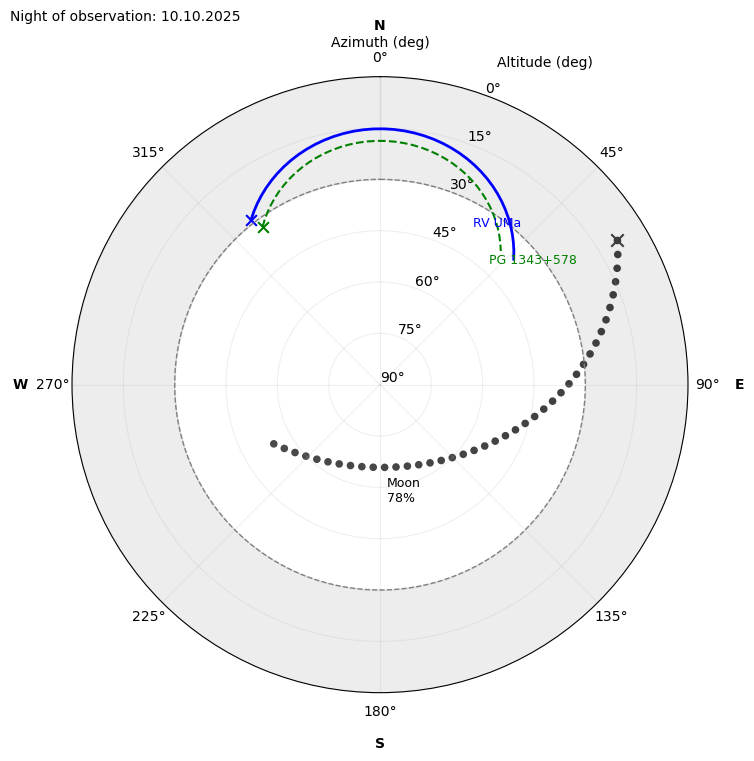

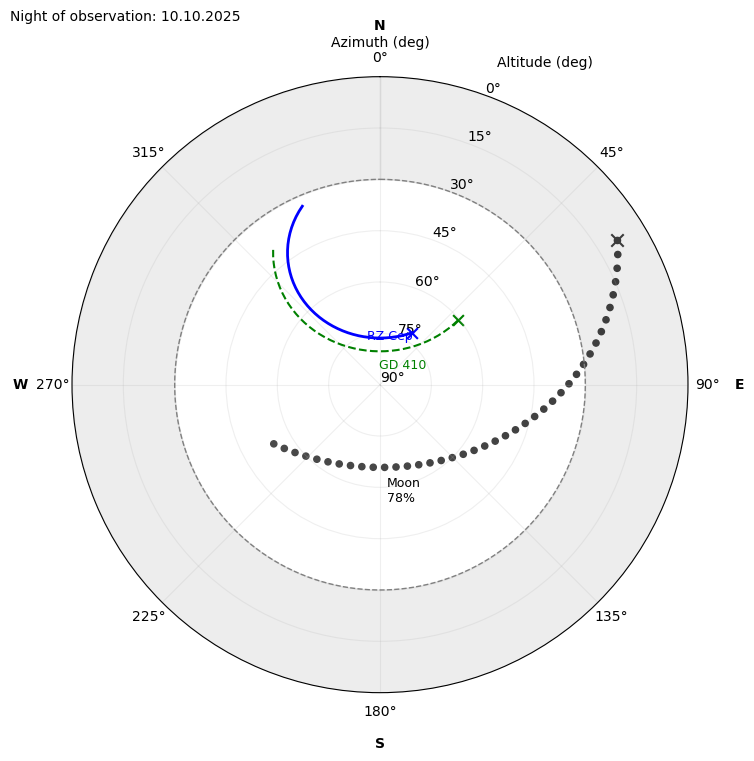

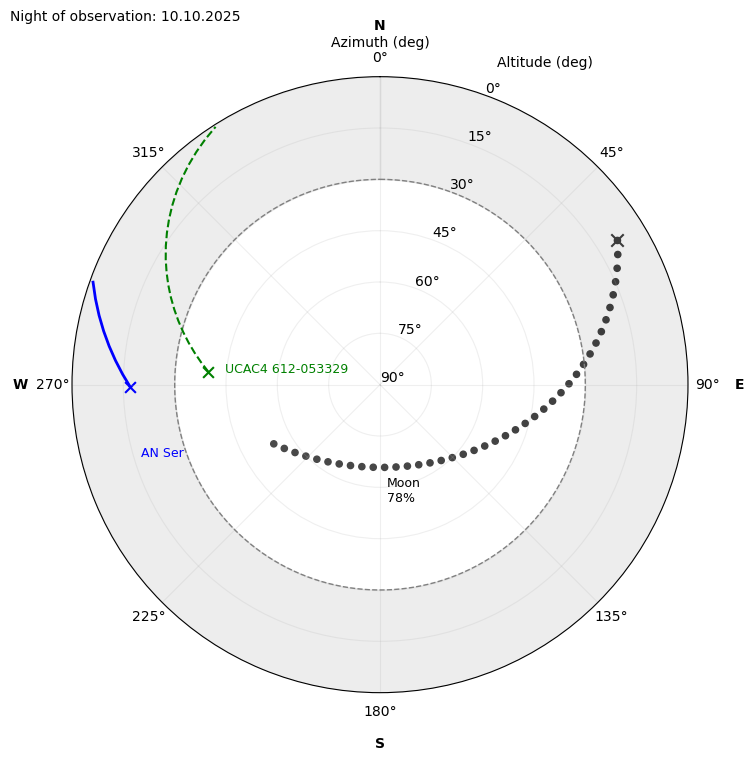

'\n#For one star across a time period\nVStar = "RZ Cep"              # Star we want to plot\nnights = 70                   # How many back to back observation nights\nfor night in range(nights):   # Loops over the date and time of observering\n    day = obs_start + TimeDelta(night, format="jd")\n    plot_night(VStar, matched, BPO, day, duration, show=False, save=True)   # Plots path of that star for the current night\n\nanimate(VStar, obs_start, nights, duration)   # Creates animation from the plots of the one star across a time period\n'

In [18]:
obs_start = Time("2025-10-10T20:00:00")        # First observation start and end date
duration = TimeDelta(10 * 3600, format="sec")  # 10 hours in seconds (20:00 -> 6:00)

plot_stars = ["RV UMa", "RZ Cep", "AN Ser"]    # Small number of example stars
#plot_stars = matched["main_id"]               # All the stars

# 'x' marker indicates the start of the paths, all paths travel clockwise around Polaris anyway
for VStar in plot_stars:    # Loops through the list of stars to plot and plots them
    plot_night(VStar, matched, BPO, obs_start, duration, show=True, save=False)

"""
#For one star across a time period
VStar = "RZ Cep"              # Star we want to plot
nights = 70                   # How many back to back observation nights
for night in range(nights):   # Loops over the date and time of observering
    day = obs_start + TimeDelta(night, format="jd")
    plot_night(VStar, matched, BPO, day, duration, show=False, save=True)   # Plots path of that star for the current night

animate(VStar, obs_start, nights, duration)   # Creates animation from the plots of the one star across a time period
"""